# MuSIC 2 
by Shahaf

In [1]:
# install the following packages
%pip install -r requirements.text > /dev/null

Note: you may need to restart the kernel to use updated packages.


The system cannot find the path specified.


# Create Models and Environmental conditions 


In [ ]:
from cobra.io import load_model, write_sbml_model, read_sbml_model , save_json_model
#online
E_model = load_model('iJO1366')
write_sbml_model(E_model, "models/Basic_Models/ecoli_iJO1366.xml")
save_json_model(E_model, "models/Basic_Models/ecoli_iJO1366.json")
S_model = load_model('iMM904')
write_sbml_model(S_model, "models/Basic_Models/scere_iMM904.xml")
save_json_model(S_model, "models/Basic_Models/scere_iMM904.json")

All_Basic_Models = [E_model, S_model]

In [3]:

#offline (if you have the models)
E_model = read_sbml_model("models/Basic_Models/ecoli_iJO1366.xml")
S_model = read_sbml_model("models/Basic_Models/scere_iMM904.xml")
All_Basic_Models = [E_model, S_model]

In [15]:
# Environmental constraints
r_glc = 'EX_glc__D_e'  # Glucose exchange
r_glyc = 'EX_glyc_e'   # Glycerol exchange
r_o2 = 'EX_o2_e'       # Oxygen exchange

# Constraints for E. coli (iJO1366)
constraints_iJO1366 = {
    'glc_aerobic': {r_glc: (-10, 0), r_glyc: (0, 0), r_o2: (-15, 1000)},
    'glc_anaerobic': {r_glc: (-20, 0), r_glyc: (0, 0), r_o2: (0, 1000)},
    'glyc_aerobic': {r_glc: (0, 0), r_glyc: (-15, 0), r_o2: (-15, 1000)},
    'glyc_anaerobic': {r_glc: (0, 0), r_glyc: (-15, 0), r_o2: (0, 1000)}
}

# Constraints for S. cerevisiae (iMM904)
constraints_iMM904 = {
    # B. Sonnleitner 1986
    'glc_aerobic': {r_glc: (-20, 0), r_glyc: (0, 0), r_o2: (-8, 1000)},
    'glc_anaerobic': {r_glc: (-20, 0), r_glyc: (0, 0), r_o2: (-0.05, 1000)},
    # Ocha-Estopier 2010
    'glyc_aerobic': {r_glc: (0, 0), r_glyc: (-4.5, 0), r_o2: (-8, 1000)}, 
    #'glyc_anaerobic': {r_glc: (0, 0), r_glyc: (-4.5, 0), r_o2: (0, 0)} # just for testing flowed the trend
}
# Conditions and target reactions
conditions_iJO1366 = ['glc_aerobic', 'glc_anaerobic', 'glyc_aerobic', 'glyc_anaerobic']
conditions_iMM904 = ['glc_aerobic', 'glc_anaerobic', 'glyc_aerobic']
target_reactions = ['EX_3hpp_e', 'EX_13ppd_e']
# Constraints and models mapping
model_constraints = {
    'iJO1366_super': constraints_iJO1366,
    'iMM904_super': constraints_iMM904,
    'iJO1366': constraints_iJO1366,
    'iMM904': constraints_iMM904
}
model_conditions = {
    'iJO1366_super': conditions_iJO1366,
    'iMM904_super': conditions_iMM904,
    'iJO1366': conditions_iJO1366,
    'iMM904': conditions_iMM904
}


# Clearing the data


## clearning the reactions data and the metablites 

    """
    Cleans and standardizes a list of metabolic reactions.
    This function performs the following operations on the input list of reactions:
    1. Replaces occurrences of '_R_' with '__R_' if '__R_' is not already present.
    2. Removes the prefix 'M_' from all reactions.
    3. Removes specific substrings from the reactions.
    4. Replaces certain substrings with new values based on a predefined dictionary.
    5. Replaces occurrences of '_D' with '__D' unless '_D' is already surrounded by underscores.
    Args:
        reactions (list of str): A list of metabolic reaction strings to be cleaned.
    Returns:
        list of str: A cleaned and standardized list of metabolic reaction strings.
    """

In [5]:
import pandas as pd
import scipy.io

# Load the Campodonico 2014 data
def load_campodonico_data(filepath):
    data = scipy.io.loadmat(filepath)
    reactions = data['react']
    pathways = data['patwy']
    metabolites = data['mets']
    return reactions, pathways, metabolites

# Print the number of reactions and pathways
def print_data_summary(reactions, pathways, metabolites):
    print(f"Reactions: {reactions.shape[0]}")
    print(f"Pathways: {pathways.shape[0]}")
    print(f"Metabolites: {metabolites.shape[0]}")

# Fix compatibility in reactions (mainly reaction representation scheme)
def fix_reactions(reactions):
    reactions_ = []
    for rxn in reactions:
        r = rxn[0][0].replace('-> ', '--> ').replace('[c]', '_c').replace('+ ', '+ ').replace('-L', '_L').replace('-D', '_D').replace('-R', '_R')
        r = r.replace('.', '_')
        reactions_.append(r)
    return reactions_

# Select only the pathways for producing 3HP and 1,3-PPD only
def select_pathways(pathways):
    pathways_3HPP = []
    pathways_13PPD = []
    for p in pathways:
        if p[1] == '3-hydroxypropanoate':
            rxns = p[0][0] - 1  # Change to 0-based counting system (MATLAB uses 1-based counting system)
            pathways_3HPP.append(rxns)
        elif p[1] == '1,3-propanediol':
            rxns = p[0][0] - 1  # Change to 0-based counting system (MATLAB uses 1-based counting system)
            pathways_13PPD.append(rxns)
    return pathways_3HPP, pathways_13PPD

# Fix the error in the dataset (with consultation from the author (Miguel Campodonico))
def fix_dataset_errors(reactions, pathways_3HPP):
    reactions.append('acrac_c + h2o_c --> 3HPP_c')
    r_num = len(reactions) - 1
    # change reaction 58 to 197 in pathways 22, 23, 24
    pathways_3HPP[22][0] = r_num
    pathways_3HPP[23][0] = r_num
    pathways_3HPP[24][0] = r_num
    return reactions, pathways_3HPP

# Clean up reactions
def clean_reactions(reactions):
    reactions = [reaction.replace('_R_', '__R_') if '__R_' not in reaction else reaction for reaction in reactions]
    df = pd.Series(reactions)
    df = df.str.replace('M_', '', regex=False)
    string_that_need_to_remove = [
        '0_3333_1_', '0_0091_2_',
        '0_1212_2_', '0_1212_1_', '0_1250_2_', '0_3750_1_','_0_3548_2',
        '_0_2813_1', '_0_2542_1','_0_4074_2','_0_5000_1','_0_1429_2'
    ]
    df = df.str.replace('|'.join(string_that_need_to_remove), '', regex=True)
    replacements = {
        '3hpp_0_2667_1': '3hppnl',        
        'lald_______D': 'lald__D',
        'lac___L': 'lald__L',
        'lac_L': 'lald__L',
        '3HPP': '3hpp',
        '13PDO': '13ppd',
        '-B': '_B',
        'mal_D_c':'mal__D_c',
        #'3hppcoa':'3hpcoa', # Hydroxypropionyl-CoA 
        #'acrlcoa':'pp2coa', #acryloyl-CoA is actually Acrylyl CoA according to the reactions 
        'acrac': 'acryl',# accourding to the reactions Acrylic acid - acryl
        
    }
    for old, new in replacements.items():
        df = df.str.replace(old, new, regex=True)
    df = df.str.replace(r'(?<!_)_D(?!_)', '__D', regex=True)
    return df.tolist()

# Main function to process the data
def process_campodonico_data(filepath):
    reactions, pathways, metabolites = load_campodonico_data(filepath)
    print_data_summary(reactions, pathways, metabolites)
    reactions = fix_reactions(reactions)
    pathways_3HPP, pathways_13PPD = select_pathways(pathways)
    reactions, pathways_3HPP = fix_dataset_errors(reactions, pathways_3HPP)
    reactions = clean_reactions(reactions)
    campodonico2014 = {
        'reactions': reactions, #class 'list' datatype
        'pathways': pathways, #numpy.ndarray datatype
        'pathways_3HPP': pathways_3HPP, #numpy.ndarray datatype
        'pathways_13PPD': pathways_13PPD, #numpy.ndarray datatype
        'metabolites': metabolites #numpy.ndarray datatype
    }
    return campodonico2014

# Example usage
campodonico2014 = process_campodonico_data('Data/Campodonico2014_matlab7.mat')

Reactions: 197
Pathways: 245
Metabolites: 144


In [6]:
import pandas as pd
import requests

dfm = pd.DataFrame(campodonico2014['metabolites'])
dfm.columns = ['id', 'InChI', 'formula']
dfm['id'] = dfm['id'].astype(str)  # Convert to string
dfmn = dfm['id']
dfm['InChI'] = dfm['InChI'].astype(str) 
dfm['formula'] = dfm['formula'].astype(str)
dfm['id']= dfm['id'].str.replace('[', '', regex=False).str.replace(']', '', regex=False)
dfm['InChI']= dfm['InChI'].str.replace('[', '', regex=False).str.replace(']', '', regex=False)
dfm['formula']= dfm['formula'].str.replace('[', '', regex=False).str.replace(']', '', regex=False)
dfmn = dfmn.str.replace(r'_0.*', '', regex=True)
dfmn = dfmn.str.replace('-D', '__D', regex=False)
dfmn = dfmn.str.replace('-L', '__L', regex=False)
dfmn = dfmn.str.replace('-R', '__R', regex=False) 
dfmn = dfmn.str.replace('-B', '_B', regex=False)
dfmn = dfmn.str.replace('-S', '__S', regex=True)
dfm['id'] = dfmn

# Search BiGG database
def search_bigg_metabolite(metabolite_id):
    url = f"http://bigg.ucsd.edu/api/v2/universal/metabolites/{metabolite_id}"
    try:
        response = requests.get(url)
        return response.json() if response.status_code == 200 else None
    except:
        return None

dfm['BiGG_Status'] = ""  # Initialize the column with empty strings
dfm['Model status'] = ""  # Initialize the column with empty strings

for index, met in enumerate(dfm['id']):
    met = met.replace("'", "")  # Remove single quotes
    met = met.replace("[", "")  # Remove
    met = met.replace("]", "")  # Remove
    result = search_bigg_metabolite(met)
    status = f"{result['name']}" if result else "Not found in BiGG"
    dfm.at[index, 'id'] = met
    # Add the status to the dataframe
    dfm.at[index, 'BiGG_Status'] = status
    found_in_models = []
    for model in All_Basic_Models:
        if met in model.metabolites:
            found_in_models.append(model.id)
        elif met + '_c' in model.metabolites or met + '_e' in model.metabolites or met + '_p' in model.metabolites:
            found_in_models.append(model.id)
    if found_in_models:
        dfm.at[index, 'Model status'] = f"Found in {', '.join(found_in_models)}"

    else:
        dfm.at[index, 'Model status'] = "Not found in any model"
dfm['Reaction'] = ""
dfm['Pathway'] = ""
# adding the reaction to the dataframe
for index, met in enumerate(dfm['id']):
    reactions_with_met = []
    for rxn in campodonico2014['reactions']:
        rxn_words = rxn.split()
        if f"{met}_c" in rxn_words or f"{met}_e" in rxn_words or f"{met}_p" in rxn_words:
            reactions_with_met.append(campodonico2014['reactions'].index(rxn))
    dfm.at[index, 'Reaction'] = ', '.join(map(str, reactions_with_met))
    pathways_with_met = []
    for i, p in enumerate(campodonico2014['pathways_3HPP'] + campodonico2014['pathways_13PPD']):
        for reaction in dfm.at[index, 'Reaction'].split(', '):
            if reaction.strip() and reaction.isdigit():  # Ensure reaction is not empty and contains only digits
                if int(reaction) in p:
                    pathways_with_met.append(p.tolist())
    dfm.at[index, 'Pathway'] = ', '.join(map(str, pathways_with_met))


# Reorder the columns
dfm = dfm[['id','BiGG_Status', 'formula' , 'Model status','Reaction','Pathway', 'InChI',]]
# Save the dataframe to a CSV file
dfm.to_csv('Data/metabolites_info_from_campodonico2014.csv', index=False)


# Add Reactions to all Models being used

## Adding Reactions to the models

This section describes the process of adding and testing reactions in a metabolic model of E. coli iJO1366 and Yeast iMM904

### Overview

This script processes metabolic models by adding pathways and reactions, optimizing the models, and tracking flux changes.

### Modules

- `csv`: For handling CSV file operations.
- `cobra`: For working with COBRA models.
- `pandas`: For handling data in DataFrame format.

### Functions

- `load_model`: Loads a COBRA model.
- `save_json_model`: Saves a COBRA model in JSON format.
- `write_sbml_model`: Saves a COBRA model in SBML format.

### Variables

- `All_Basic_Models`: List of basic COBRA models to be processed.
- `pathways_13PPD`: Pathways related to 13PPD.
- `pathways_3HPP`: Pathways related to 3HPP.
- `reactions`: Dictionary of reactions.
- `pathways`: Dictionary of pathways.
- `exchange_reactions`: List of exchange reactions.
- `pathways_all`: Combined list of all pathways and exchange reactions.
- `model_configs`: List of configurations for each model, including model, name, output file, and model path.

### Processing Steps

1. **Initialize tracking variables for each model.**
2. **Optimize the basic model and print initial flux and total reactions.**
3. **Initialize the output CSV file.**
4. **Process each constraint condition:**
    - Add pathways and reactions to the model.
    - Parse reaction equations and add metabolites.
    - Optimize the model and track flux changes.
    - Write significant flux changes to the output CSV file.
    - Remove reactions if no significant flux change is observed.
5. **Save the updated model in SBML and JSON formats.**
6. **Print summary of results, including new growth flux, total reactions added, and total reactions with flux changes.**

### Exceptions

- Handles exceptions during reaction equation parsing and optimization.

In [7]:
# checking for duplicates in the model
import pandas as pd
from pandas import read_csv
from cobra import Model, Metabolite, Reaction

# Initialize the list to collect rows
rows = []

# Define the reaction equation to match

#df = read_csv(r'C:\Users\shaco\OneDrive\Work-Coding\Github-projects\MuSIC2\Data\reactions.csv')
df = pd.DataFrame(campodonico2014['reactions'])
reaction_eqs = df.values.tolist()
print(len(reaction_eqs))

# Function to split the reaction equation and clean whitespace
def met(reaction_eq_list):
    return [[met for met in eq.split(' ') if met not in ('-->', '+')] for eq in reaction_eq_list]

# Function to clean metabolite IDs
def clean_metabolite_dict(metabolite_dict):
    return [met.id for met in metabolite_dict.keys()]

# Function to split reaction into reactants and products
def split_reaction(reaction_str):
    if ' --> ' in reaction_str:
        reactants, products = reaction_str.split(' --> ')
    elif ' <-> ' in reaction_str:
        reactants, products = reaction_str.split(' <-> ')
    else:
        reactants = reaction_str.split(' + ')
        products = []
    if isinstance(reactants, str):
        reactants = [met.strip() for met in reactants.split(' + ')]
    elif isinstance(reactants, list):
        reactants = [met.strip() for met in reactants]
    if isinstance(products, str):
        products = [met.strip() for met in products.split(' + ')]
    elif isinstance(products, list):
        products = [met.strip() for met in products]
    return reactants, products

for model in All_Basic_Models:
    for reaction_eq in reaction_eqs:
        # Iterate through the reactions in the model
        for reaction in model.reactions:
            # Attempt to access the reaction
            model.reactions.get_by_id(reaction.id)
            
            # Clean the metabolite IDs
            reaction_metabolites = clean_metabolite_dict(reaction.metabolites)
            target_metabolites = met(reaction_eq)[0]
            
            # Split the reaction and target reaction into reactants and products
            reaction_reactants, reaction_products = split_reaction(reaction.reaction)
            target_reactants, target_products = split_reaction(reaction_eq[0])
            
            # Check if the direction and metabolites match
            if (set(reaction_reactants) == set(target_reactants) and set(reaction_products) == set(target_products)):
                # Check if the reaction already exists in the model
                if reaction.id not in [r['reaction'] for r in rows]:
                    # Add the reaction to the list of rows
                    rows.append({'reaction': reaction.id, 'reaction_eq': reaction.reaction, 'model': model.id, 'reaction_index': reaction_eqs.index(reaction_eq) ,'new ID': f"R_Campodonico_{int(reaction_eqs.index(reaction_eq))}"})
                    print(f"Added reaction: {reaction.id}, {reaction.reaction}")
                    model.reactions.get_by_id(reaction.id).id = f"R_Campodonico_{int(reaction_eqs.index(reaction_eq))}"
                    

# Convert the list of rows to a DataFrame
df_dop = pd.DataFrame(rows)

# Display the DataFrame
df_dop

198
Added reaction: MSAR, h_c + msa_c + nadph_c --> 3hpp_c + nadp_c
Added reaction: GLYCLTDx, glx_c + h_c + nadh_c --> glyclt_c + nad_c
Added reaction: GLYCLTDy, glx_c + h_c + nadph_c --> glyclt_c + nadp_c
Added reaction: PGLYCP, 2pglyc_c + h2o_c --> glyclt_c + pi_c


,reaction,reaction_eq,model,reaction_index,new ID
0,MSAR,h_c + msa_c + nadph_c --> 3hpp_c + nadp_c,iJO1366,44,R_Campodonico_44
1,GLYCLTDx,glx_c + h_c + nadh_c --> glyclt_c + nad_c,iJO1366,59,R_Campodonico_59
2,GLYCLTDy,glx_c + h_c + nadph_c --> glyclt_c + nadp_c,iJO1366,61,R_Campodonico_61
3,PGLYCP,2pglyc_c + h2o_c --> glyclt_c + pi_c,iJO1366,65,R_Campodonico_65


In [8]:
import csv
import cobra
import pandas as pd
from cobra import Reaction, Metabolite
from cobra.io import save_json_model, write_sbml_model

# load Data 
pathways_13PPD = campodonico2014['pathways_13PPD']  # Define your pathways_13PPD
pathways_3HPP = campodonico2014['pathways_3HPP']  # Define your pathways_3HPP
reactions = campodonico2014['reactions']  # Define your reactions
pathways = campodonico2014['pathways']

exchange_reactions =[{
    '3hpp_tr': '3hpp_e <-> 3hpp_c',
    '13ppd_tr': '13ppd_e <-> 13ppd_c',
    'EX_13ppd_e': '13ppd_e --> ',
    'EX_3hpp_e': '3hpp_e --> '
}]  # Define your exchange reactions

pathways_all = exchange_reactions + pathways_13PPD + pathways_3HPP
# Define models and their configurations

model_configs = [
    {
        'model': model,
        'name': f"Model_{model.id}",
        'output_file': f"Data/flux_changes_Model_{model.id}.csv",
        'model_path': f"models/Model_{model.id}_update"
    }
    for model in All_Basic_Models
]

# Process each model
for config in model_configs:
    model = config['model'].copy()
    model_name = config['name']
    output_file = config['output_file']
    model.id = f'{model.id}_super'
    # Initialize tracking variables for this model
    reactions_13PPD = {}
    reactions_3HPP = {}
    rxns = []
    rxns_all = []
    failed_reactions = []
    problematic_metabolites = []
    rxns_13PPD = []
    rxns_3HPP = []

    basic_model = model.copy()
    basic_solution = basic_model.optimize()
    basic_flux = basic_solution.objective_value
    print(f"Initial flux of BioMass {model_name}: {basic_flux:.6f}")
    print(f"Basic {model_name} model Total reactions: {len(basic_model.reactions)}")
    # Initialize output file
    with open(output_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Reaction ID", "Reaction Equation", "Flux Change","Pathway", "Model Name", "Condition"])
    # Add pathways
    for pathway_idx, pathway in enumerate(pathways_all):  # Iterate through pathways
        
        for reaction_idx in pathway:  # Iterate through reactions in each pathway

            # Handle reaction name and equation based on type
            if isinstance(reaction_idx, str):
                # Transport/exchange reaction
                reaction_name = reaction_idx
                reaction_equation = exchange_reactions[0][reaction_idx]
            else:
                # Pathway reaction
                reaction_name = f"R_Campodonico_{int(reaction_idx)}"
                reaction_equation = reactions[int(reaction_idx)]
                rxns.append(int(reaction_idx))


            if reaction_name in rxns_all:
                continue
            if reaction_name in model.reactions:
                continue
            
            reaction = Reaction(reaction_name)
            # Parse the reaction equation
            metabolites = {}
            if "<->" in reaction_equation:
                reactants, products = reaction_equation.split("<->")
                reaction.lower_bound = -1000.0
            else:
                reactants, products = reaction_equation.split("-->")
                reaction.lower_bound = 0.0

            for part, stoich in zip([reactants, products], [-1.0, 1.0]):
                for item in part.strip().split('+'):
                    metabolite_id = item.strip()
                    if metabolite_id:
                        if metabolite_id not in model.metabolites:
                            compartment = "e" if metabolite_id.endswith("_e") else "c"
                            metabolite = Metabolite(metabolite_id, compartment=compartment)
                            model.add_metabolites([metabolite])
                        else:
                            metabolite = model.metabolites.get_by_id(metabolite_id)
                        metabolites[metabolite] = stoich

            for metabolite in model.metabolites:
                if metabolite.compartment is None or metabolite.compartment == '':
                    problematic_metabolites.append(metabolite)
                    metabolite.compartment = 'c'

            reaction.add_metabolites(metabolites)
            model.add_reactions([reaction])
            try:
                reaction.reaction = reaction_equation
            except Exception as e:
                failed_reactions.append((reaction_name, str(e)))

            solution = model.optimize()
            current_flux = solution.objective_value
            if model_name == 'iJO1366': # E. coli 
                lower_flux_limit = 0.00001 #1e-6: # 0.1
            else: # S. cerevisiae
                lower_flux_limit = 0.00001
            if abs(current_flux - basic_flux) > lower_flux_limit: # Check if the flux change is significant
                
                flux_change = current_flux - basic_flux
                with open(output_file, mode="a", newline="") as file:
                    writer = csv.writer(file)
                    writer.writerow([reaction_name, reaction_equation, f"{flux_change:.6f}", pathway, model_name])
                if reaction_name not in exchange_reactions: # Exclude exchange reactions
                     model.remove_reactions([reaction])
            else:

                rxns_all.append(reaction_name)
                if reaction_name in reactions_13PPD:
                    rxns_13PPD.append(reaction_name)
                elif reaction_name in reactions_3HPP:
                    rxns_3HPP.append(reaction_name)
    # Save the model with the name of the model, condition, and pathways
    model_name_condition_pathways = f"{model_name}_super.xml"
    cobra.io.write_sbml_model(model, f"models/New/{model_name_condition_pathways}")

    model_name_condition_pathways_json = f"{model_name}_super.json"
    cobra.io.save_json_model(model, f"models/New/{model_name_condition_pathways_json}")
    
    print(f"New Growth Flux for {model_name} : { model.optimize().objective_value }")
    print(f"Total reactions added: {len(model.reactions) - len(basic_model.reactions)}")
    print(f"Updated model saved. Total reactions: {len(model.reactions)}")
    print(f"Results saved to: {output_file}")
    print(f"Total reactions with flux changes: {len(pd.read_csv(output_file))}")


Initial flux of BioMass Model_iJO1366: 0.982372
Basic Model_iJO1366 model Total reactions: 2583
New Growth Flux for Model_iJO1366 : 0.982373175661897
Total reactions added: 48
Updated model saved. Total reactions: 2631
Results saved to: Data/flux_changes_Model_iJO1366.csv
Total reactions with flux changes: 16
Initial flux of BioMass Model_iMM904: 0.287866
Basic Model_iMM904 model Total reactions: 1577
New Growth Flux for Model_iMM904 : 0.28787513280294774
Total reactions added: 60
Updated model saved. Total reactions: 1637
Results saved to: Data/flux_changes_Model_iMM904.csv
Total reactions with flux changes: 4


# Test on how to grather flux data for pathways

In [11]:
# Load the COBRA model 
from cobra.io import read_sbml_model, load_json_model

# Load the updated E. coli model from the JSON file
E_model = load_json_model('models/New/Model_iJO1366_super.json') 

# Load the updated S. cerevisiae model from the JSON file
S_model = load_json_model('models/New/Model_iMM904_super.json')

# Set the model IDs for clarity
E_model.id = 'iJO1366_super'
S_model.id = 'iMM904_super'

# Store the updated models in a list for further processing
All_Updated_Models = [E_model, S_model]


Current objective function: Maximize
1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Initial flux of BIOMASS:  0.28224455518618186


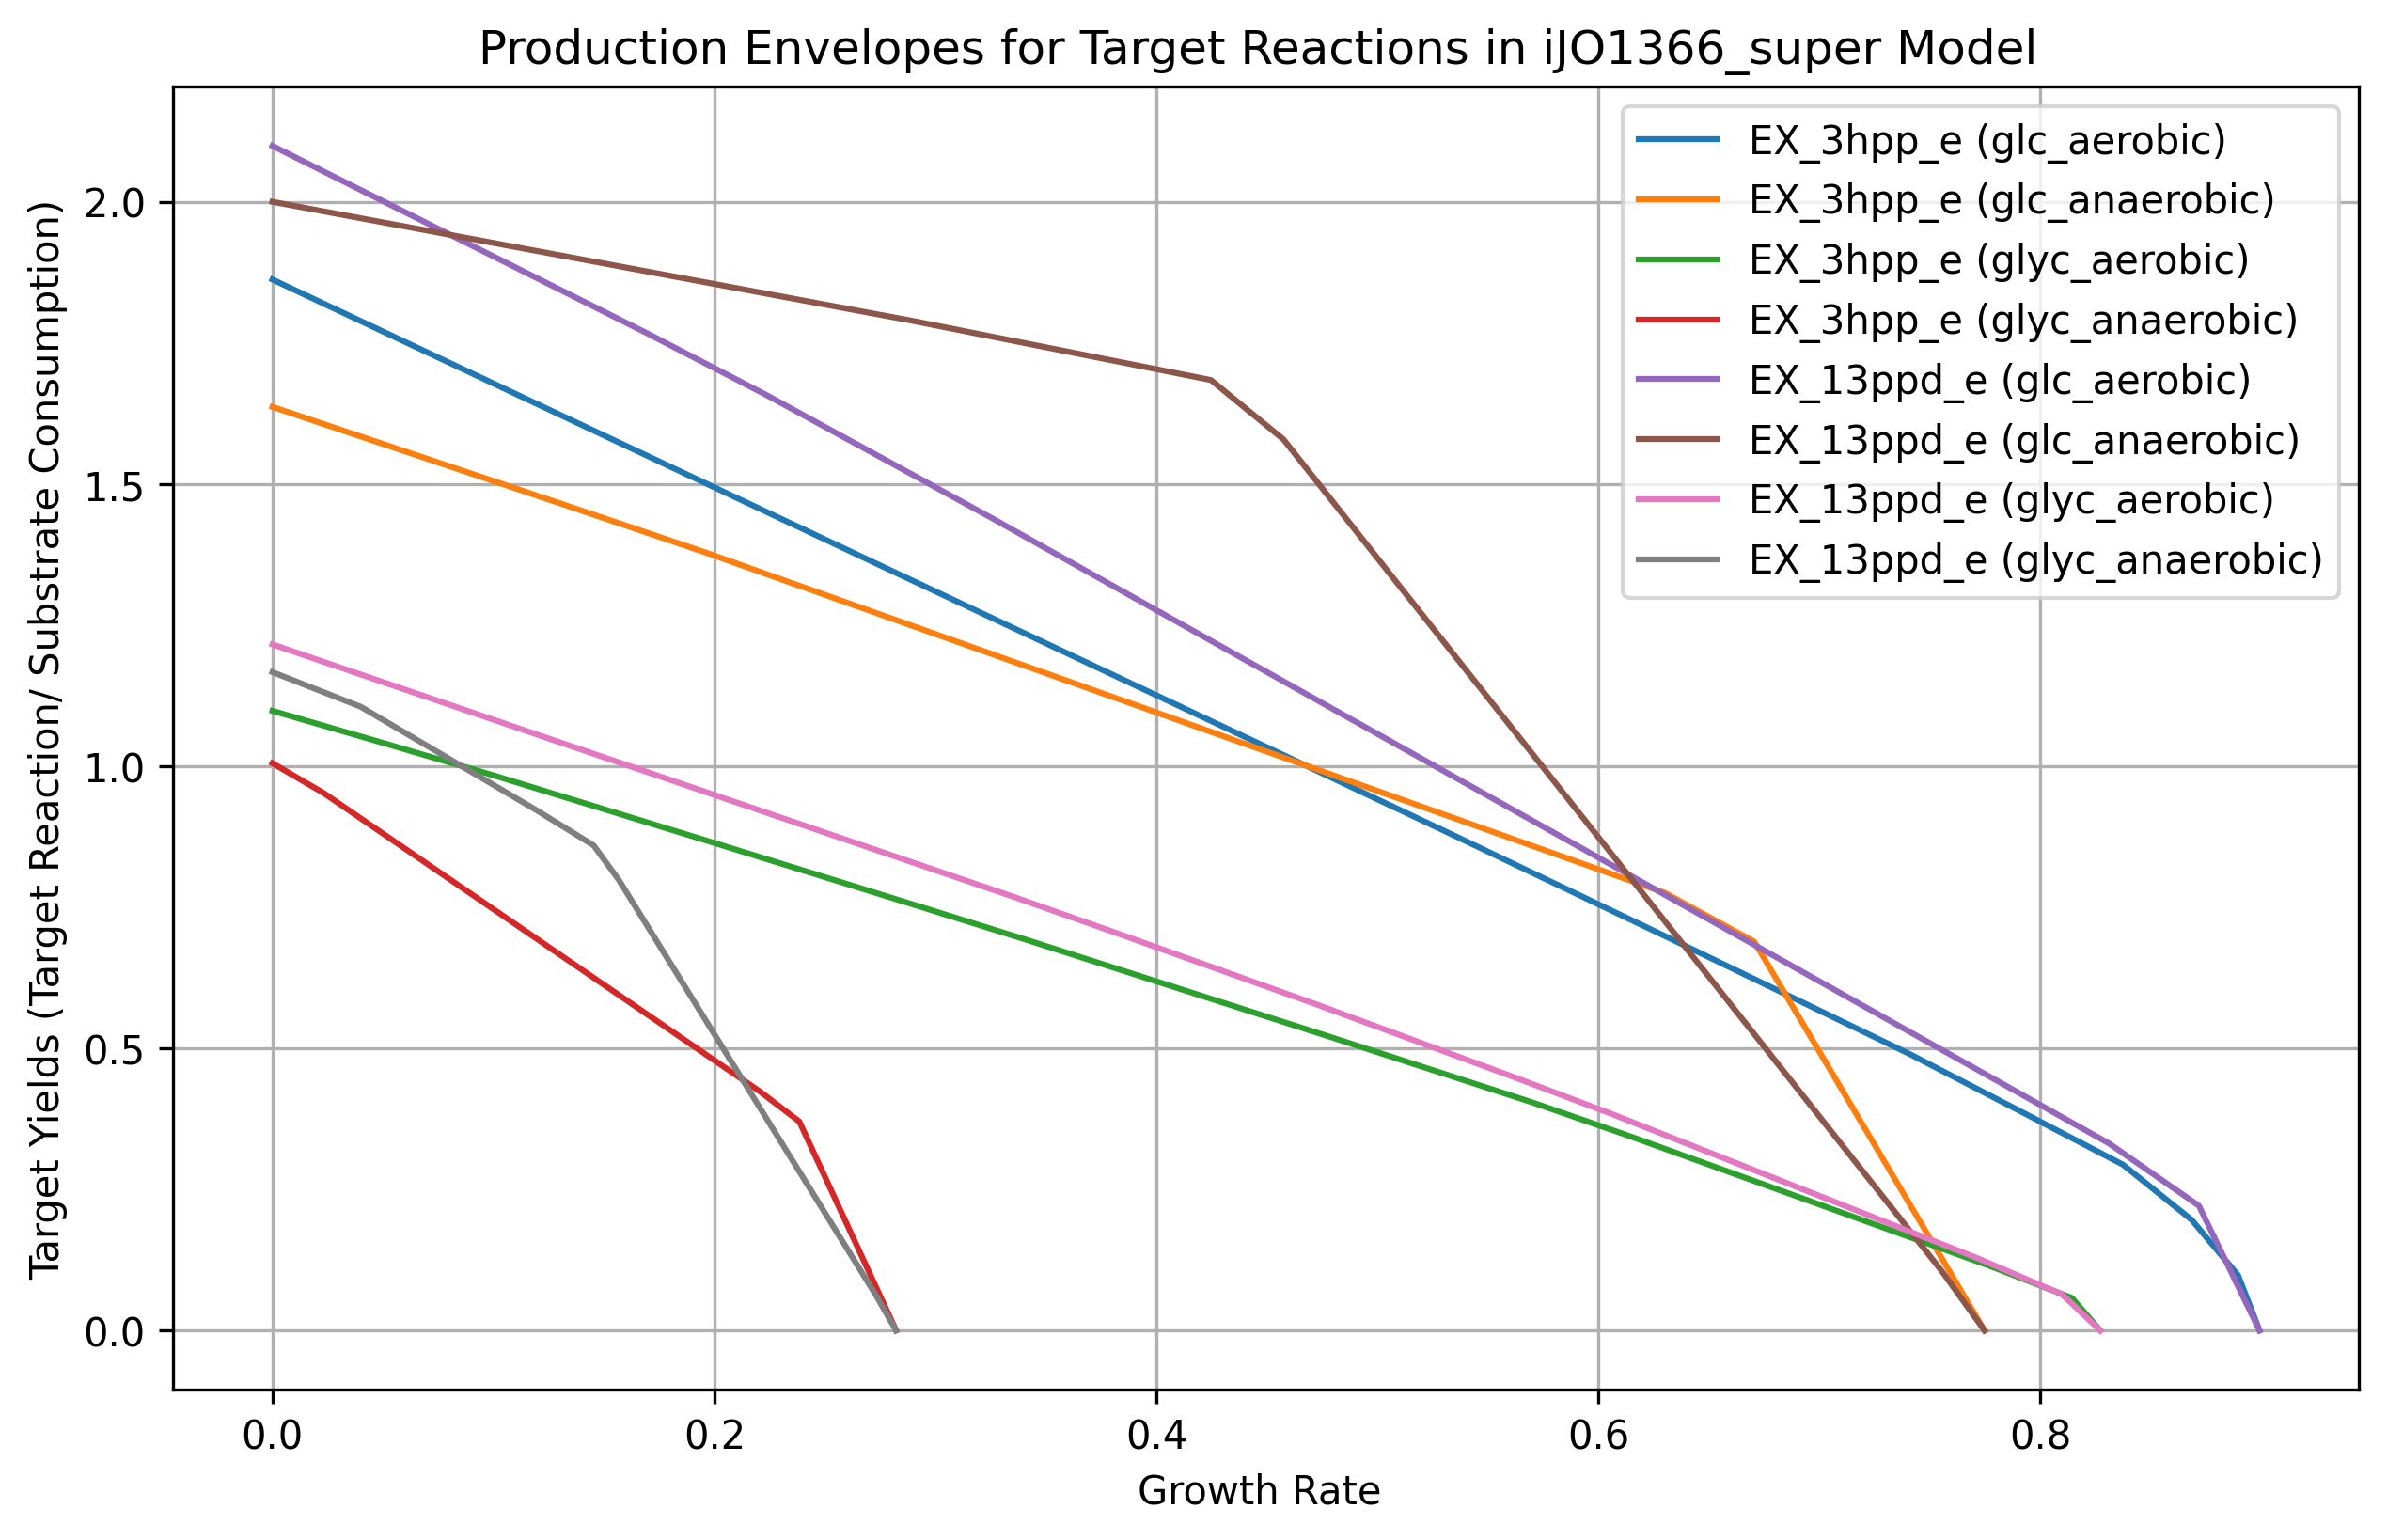

Current objective function: Maximize
1.0*BIOMASS_SC5_notrace - 1.0*BIOMASS_SC5_notrace_reverse_93090
Initial flux of BIOMASS:  0.2401922605289999


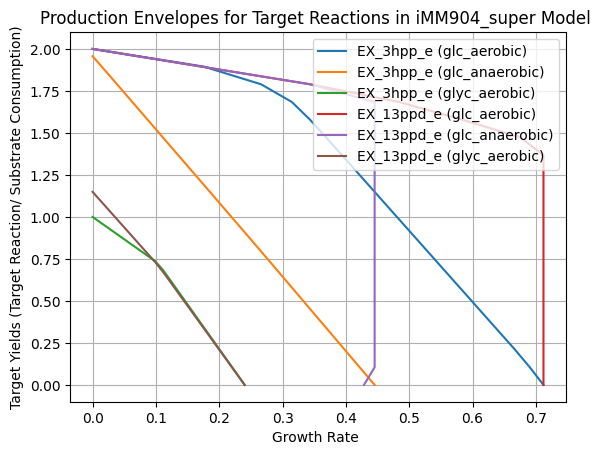

In [16]:


# Import necessary modules
from cobra.flux_analysis import production_envelope
import matplotlib.pyplot as plt
import pandas as pd

# Initialize the list to store the fluxes of the reactions
reaction_flux_records = []
data_records = []

# Plot production envelopes
plt.figure(dpi=300, figsize=(10, 6))

# Iterate over each updated model
for model in All_Updated_Models:
    # Print the current objective function
    print("Current objective function:", model.objective) # display 
    print("Initial flux of BIOMASS: ", model.optimize().objective_value)
    
    # Define the reactions from the Campodonico 2014 dataset
    campodonico_reactions = [
        rxn for rxn in model.reactions if "R_Campodonico" in rxn.id
    ]
    
    # Iterate over target reactions
    for target_reaction in target_reactions:
        # Get constraints for the current model
        constraints = model_constraints[model.id]
        conditions = model_conditions[model.id]
        
        # Iterate over each condition
        for condition in conditions:
            # Get condition-specific constraints
            constraint = constraints[condition]

            # Apply the constraints to the model
            for rxn_id, bounds in constraint.items():
                model.reactions.get_by_id(rxn_id).bounds = bounds
            
            # Run production envelope analysis
            prod_env = production_envelope(model, reactions=[target_reaction], points=20)

            # Determine substrate flux for yield calculation
            if 'glyc' in condition:
                substrate_flux = abs(constraint[r_glyc][0])
            else:
                substrate_flux = abs(constraint[r_glc][0])
            
            # Calculate target yields (flux_maximum divided by substrate_flux)
            target_yields = prod_env[target_reaction] / substrate_flux

            # Iterate over the production envelope results
            for i, growth_rate in enumerate(prod_env['flux_maximum']):
                model.optimize()  # Optimize the model to extract fluxes

                # Get fluxes for reactions in the Campodonico dataset
                for reaction in campodonico_reactions:
                    if reaction.flux != 0:
                        reaction_flux_records.append({
                            'condition': condition,
                            'target_reaction': target_reaction,
                            'target product flux': prod_env[target_reaction][i],
                            'growth_rate': growth_rate,
                            'model ID': model.id,
                            'reaction_id': reaction.id,
                            'flux': reaction.flux,
                        })
            # Store the production envelope data
            data_records.append(prod_env)
            
            # Plot production envelope
            plt.plot(prod_env['flux_maximum'], target_yields, label=f"{target_reaction} ({condition})")

# Add labels and legend to the plot
plt.xlabel('Growth Rate')
plt.ylabel('Target Yields (Target Reaction / Substrate Consumption)')
plt.title(f'Production Envelopes for Target Reactions in {model.id} Model')
plt.legend()
plt.grid(True)
plt.show()

# Convert the reaction flux records to a DataFrame
df_reaction_flux = pd.DataFrame(reaction_flux_records)


In [32]:
import pandas as pd


# Initialize the 'Pathways' and 'Pathway Type' columns
df_reaction_flux['Pathways'] = ""
df_reaction_flux['Pathway Type'] = ""

# Combine pathways from both sources
all_pathways = campodonico2014['pathways_3HPP'] + campodonico2014['pathways_13PPD']

# Iterate over the DataFrame
for index, row in df_reaction_flux.iterrows():
    if 'R_Campodonico' not in row['reaction_id'] :
            continue
    reaction_id = row['reaction_id'].replace('R_Campodonico_', '')
    condition = row['condition']
    target_reaction = row['target_reaction']
    flux = row['flux']
    model = row['model ID']
    
    # Check if the reaction has a positive flux
    if flux != 0:
        pathway_check = []
        pathway_types = set()
        
        # Check if the reaction is in any pathway
        for pathway in all_pathways:
            pathway_list = list(pathway)  # Convert pathway to list
            if int(reaction_id) in pathway_list:  # Ensure reaction_id is an integer
                # Check if any reaction in the same pathway has positive flux
                for rxn_id in pathway_list:
                    other_flux = df_reaction_flux[
                        (df_reaction_flux['reaction_id'] == f'R_Campodonico_{rxn_id}') &
                        (df_reaction_flux['condition'] == condition) & 
                        (df_reaction_flux['model ID'] == model) &
                        (df_reaction_flux['target_reaction'] == target_reaction)
                    ]['flux'].values
                    
                    if len(other_flux) > 0 and other_flux[0] != 0:
                        # Convert np.uint8 to int and add the entire pathway as a list
                        pathway_check.append([int(r) for r in pathway_list])
                        
                        # Determine the pathway type
                        if pathway_list in [list(p) for p in campodonico2014['pathways_3HPP']]:
                            pathway_types.add('3HPP')
                        if pathway_list in [list(p) for p in campodonico2014['pathways_13PPD']]:
                            pathway_types.add('13PPD')
                        break  # No need to check further if one reaction in the pathway has positive flux
        
        # Add the list of pathways to the 'Pathways' column
        df_reaction_flux.at[index, 'Pathways'] = str(pathway_check)
        
        # Add the pathway types to the 'Pathway Type' column
        df_reaction_flux.at[index, 'Pathway Type'] = ', '.join(pathway_types)


# Save the results to CSV files
df_reaction_flux.to_csv(f'Data/IDK/reaction_flux_results.csv', index=False)

In [19]:
import pandas as pd
from cobra.io import load_json_model

# Load the metabolites information from the CSV file
metabolites_info = pd.read_csv('Data/metabolites_info_from_campodonico2014.csv')

# Initialize the dictionary to store shadow prices
shadow_prices = {
    'model': [],
    'metabolite': [],
    'metabolite_c': [],
    'metabolite_e': [],
    'metabolite_p': [],
    'shadow_price': [],
    'shadow_price_c': [],
    'shadow_price_e': [],
    'shadow_price_p': []
}

# Assuming All_Updated_Models is a list of COBRA models
All_Updated_Models
# Iterate over each model
for model in All_Updated_Models:
    # Optimize the model once and get the shadow prices
    solution = model.optimize()
    for met_id in metabolites_info['id']:
        meta_id_1 = None
        meta_id_2 = None
        meta_id_3 = None
        shadow_price_e = None
        shadow_price_c = None
        shadow_price_p = None
        shadow_price = None
        
        if met_id in model.metabolites:
            shadow_price = solution.shadow_prices[met_id]
        if met_id + '_c' in model.metabolites:
            meta_id_1 = met_id + '_c'
            shadow_price_c = solution.shadow_prices[met_id + '_c']
        if met_id + '_e' in model.metabolites:
            meta_id_2 = met_id + '_e'
            shadow_price_e = solution.shadow_prices[met_id + '_e']
        if met_id + '_p' in model.metabolites:
            meta_id_3 = met_id + '_p'
            shadow_price_p = solution.shadow_prices[met_id + '_p']
        else:
            shadow_price = None
        print(f"Shadow price of {met_id} in {model.id} model: {shadow_price}")
        
        # Append the results to the lists within the dictionary
        shadow_prices['model'].append(model.id)
        shadow_prices['metabolite'].append(met_id)
        shadow_prices['metabolite_c'].append(meta_id_1)
        shadow_prices['metabolite_e'].append(meta_id_2)
        shadow_prices['metabolite_p'].append(meta_id_3)
        shadow_prices['shadow_price'].append(shadow_price)
        shadow_prices['shadow_price_c'].append(shadow_price_c)
        shadow_prices['shadow_price_e'].append(shadow_price_e)
        shadow_prices['shadow_price_p'].append(shadow_price_p)



# Convert the dictionary to a DataFrame for easier manipulation and visualization
shadow_prices_df = pd.DataFrame(shadow_prices)


Shadow price of ala_B in iJO1366_super model: None
Shadow price of aa in iJO1366_super model: None
Shadow price of h2o in iJO1366_super model: None
Shadow price of 3hpp in iJO1366_super model: None
Shadow price of nh4 in iJO1366_super model: None
Shadow price of acryl in iJO1366_super model: None
Shadow price of b2coa in iJO1366_super model: None
Shadow price of succ in iJO1366_super model: None
Shadow price of succoa in iJO1366_super model: None
Shadow price of ppcoa in iJO1366_super model: None
Shadow price of o2 in iJO1366_super model: None
Shadow price of h2o2 in iJO1366_super model: None
Shadow price of ac in iJO1366_super model: None
Shadow price of accoa in iJO1366_super model: None
Shadow price of coa in iJO1366_super model: None
Shadow price of oxam in iJO1366_super model: None
Shadow price of nadh in iJO1366_super model: None
Shadow price of h in iJO1366_super model: None
Shadow price of nad in iJO1366_super model: None
Shadow price of op4en in iJO1366_super model: None
Shado

In [20]:
shadow_prices_df[shadow_prices_df['metabolite'].str.contains('3hpp') | shadow_prices_df['metabolite'].str.contains('13ppd')]

,model,metabolite,metabolite_c,metabolite_e,metabolite_p,shadow_price,shadow_price_c,shadow_price_e,shadow_price_p
3,iJO1366_super,3hpp,3hpp_c,3hpp_e,3hpp_p,None,-0.002628,-0.000000,-0.0
65,iJO1366_super,3hpp,3hpp_c,3hpp_e,3hpp_p,None,-0.002628,-0.000000,-0.0
74,iJO1366_super,3hppcoa,3hppcoa_c,None,None,None,-0.368793,NaN,NaN
104,iJO1366_super,13ppd,13ppd_c,13ppd_e,None,None,-0.000000,-0.000000,NaN
147,iMM904_super,3hpp,3hpp_c,3hpp_e,None,None,-0.029802,-0.029802,NaN
209,iMM904_super,3hpp,3hpp_c,3hpp_e,None,None,-0.029802,-0.029802,NaN
218,iMM904_super,3hppcoa,3hppcoa_c,None,None,None,-0.371583,NaN,NaN
248,iMM904_super,13ppd,13ppd_c,13ppd_e,None,None,-0.042575,-0.042575,NaN
